# **LSTM of Amazon Fine Food Reviews**

In [1]:
#installing keras and tensorflow
!pip install keras
!pip install tensorflow
!pip install nltk
import nltk # natural language processing toolkit used for Natural language processing NLP
import matplotlib.pyplot as plt
import seaborn as sb
import time
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Credits: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/
# LSTM for sequence classification in the IMDB dataset
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## **Implementing LSTM on Amazon Fine Food Reviews using Keras**

In [3]:
# Loading already cleaned datafile
final = pd.read_csv("./final.csv", engine = "python")
print(final.shape)

(364171, 14)


In [4]:
###Sorting as we want according to time 
final.sort_values('Time',inplace=True)

In [5]:
#filtering out null records
filtered_df = final[final['CleanedText_NoStem'].notnull()]
filtered_df.shape

(364168, 14)

In [6]:
filtered_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText_NoStem,CleanedText,CleanedText_NoStem_utf,CleanedText_utf
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,1999-10-08 00:00:00,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,witti littl book make son laugh loud recit car...,b'witty little book makes son laugh loud recit...,b'witti littl book make son laugh loud recit c...
30,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,1999-10-25 00:00:00,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...,rememb see show air televis year ago child sis...,b'remember seeing show aired television years ...,b'rememb see show air televis year ago child s...
424,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,1999-12-02 00:00:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...,beetlejuic well written movi everyth excel act...,b'beetlejuice well written movie everything ex...,b'beetlejuic well written movi everyth excel a...
330,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,1999-12-06 00:00:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...,twist rumplestiskin captur film star michael k...,b'twist rumplestiskin captured film starring m...,b'twist rumplestiskin captur film star michael...
423,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,2000-01-03 00:00:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...,beetlejuic excel funni movi keaton hilari wack...,b'beetlejuice excellent funny movie keaton hil...,b'beetlejuic excel funni movi keaton hilari wa...


In [7]:
filtered_df['Score'].value_counts()

positive    307058
negative     57110
Name: Score, dtype: int64

In [8]:
# Splitting all the words into a list 
    i=0
    all_words=[]
    for sent in tqdm(final['CleanedText_NoStem'].astype(str).values):
        for w in sent.split():
            w=(w.lower())
            all_words.append(w)


100%|██████████| 364171/364171 [00:06<00:00, 56433.62it/s]


In [9]:
#printing top 20 most commonly occouring words with there frequency count
freq_dist=nltk.FreqDist(all_words)
print("frequenies of Words : ",freq_dist.most_common(20))

frequenies of Words :  [('not', 198672), ('like', 152093), ('good', 121423), ('great', 106024), ('one', 104198), ('taste', 102063), ('product', 95543), ('coffee', 85790), ('flavor', 85291), ('tea', 83561), ('love', 79221), ('would', 72981), ('get', 66662), ('really', 61746), ('food', 61246), ('dont', 57474), ('use', 56738), ('much', 56452), ('also', 53050), ('time', 51719)]


In [10]:
# converting frequency distribution to word vocabulary
vocabulary = dict(freq_dist)

In [11]:
iterator = iter(vocabulary.items())
for i in range(5):
    print(next(iterator))

('witty', 11)
('little', 51532)
('book', 1518)
('makes', 23825)
('son', 6630)


In [12]:
# Function to sort and Rank 'n' words in vocabulary 
def top_words(top,vocab):
    #https://docs.python.org/3/library/operator.html
    import operator
    sorted_vocab = sorted(vocab.items(), key=operator.itemgetter(1),reverse = True)
    sorted_vocab=sorted_vocab[1:top+1] # eliminated not by starting from index 1 
    
    ranking = dict()
    rank = 1
    for i in range(len(sorted_vocab)):
        k = sorted_vocab[i][0]
        ranking[k] = rank
        rank+=1
    return ranking

In [13]:
top_rank_word = 5000
ranking = top_words(top_rank_word, vocabulary)


In [14]:
print("top 5 words")
iterator = iter(ranking.items())
for i in range(5):
    print(next(iterator))

top 5 words
('like', 1)
('good', 2)
('great', 3)
('one', 4)
('taste', 5)


In [15]:
len(ranking)

5000

In [16]:
# replacing every all words in every single review with ranks of of the words and converting all reviews into ranked word reviews
"""
Very Very slow technique
X = []    
for sent in tqdm(final['CleanedText_NoStem'].astype(str).values):
    row =[]
    for w in sent.split():
        for key, value in ranking.items():
            if w == key:
                row.append(value)
            else:
                row.append(0)
            
    X.append(row)"""    

# alternate equivalent technique to above and very very fast
X = []    
for sent in tqdm(final['CleanedText_NoStem'].astype(str).values):
    row =[]
    for w in sent.split():
        if w in ranking:
            row.append(ranking[w]) 
        else:
            row.append(0)    
            
    X.append(row)
    
final['CleandText_NoStem_indexed'] = X

final['Score'] = final['Score'].map(lambda x : 1 if x == 'positive' else 0)
final.head(5)

100%|██████████| 364171/364171 [00:09<00:00, 37010.97it/s]


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText_NoStem,CleanedText,CleanedText_NoStem_utf,CleanedText_utf,CleandText_NoStem_indexed
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08 00:00:00,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,witti littl book make son laugh loud recit car...,b'witty little book makes son laugh loud recit...,b'witti littl book make son laugh loud recit c...,"[0, 20, 1414, 77, 396, 4915, 4419, 0, 1267, 32..."
30,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25 00:00:00,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...,rememb see show air televis year ago child sis...,b'remember seeing show aired television years ...,b'rememb see show air televis year ago child s...,"[625, 1609, 1300, 0, 0, 74, 294, 1079, 1453, 5..."
424,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02 00:00:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...,beetlejuic well written movi everyth excel act...,b'beetlejuice well written movie everything ex...,b'beetlejuic well written movi everyth excel a...,"[0, 30, 2338, 1534, 330, 160, 0, 455, 1219, 14..."
330,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06 00:00:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...,twist rumplestiskin captur film star michael k...,b'twist rumplestiskin captured film starring m...,b'twist rumplestiskin captur film star michael...,"[2594, 0, 0, 3425, 0, 0, 0, 0, 0, 992, 4198, 0..."
423,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03 00:00:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...,beetlejuic excel funni movi keaton hilari wack...,b'beetlejuice excellent funny movie keaton hil...,b'beetlejuic excel funni movi keaton hilari wa...,"[0, 160, 1631, 1534, 0, 0, 0, 0, 3, 455, 1219,..."


In [17]:
#Taking sample Data
n_samples = 100000
sample = final.head(n_samples)

In [18]:
sample.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText_NoStem,CleanedText,CleanedText_NoStem_utf,CleanedText_utf,CleandText_NoStem_indexed
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08 00:00:00,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,witti littl book make son laugh loud recit car...,b'witty little book makes son laugh loud recit...,b'witti littl book make son laugh loud recit c...,"[0, 20, 1414, 77, 396, 4915, 4419, 0, 1267, 32..."
30,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25 00:00:00,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...,rememb see show air televis year ago child sis...,b'remember seeing show aired television years ...,b'rememb see show air televis year ago child s...,"[625, 1609, 1300, 0, 0, 74, 294, 1079, 1453, 5..."
424,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02 00:00:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...,beetlejuic well written movi everyth excel act...,b'beetlejuice well written movie everything ex...,b'beetlejuic well written movi everyth excel a...,"[0, 30, 2338, 1534, 330, 160, 0, 455, 1219, 14..."
330,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06 00:00:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...,twist rumplestiskin captur film star michael k...,b'twist rumplestiskin captured film starring m...,b'twist rumplestiskin captur film star michael...,"[2594, 0, 0, 3425, 0, 0, 0, 0, 0, 992, 4198, 0..."
423,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03 00:00:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...,beetlejuic excel funni movi keaton hilari wack...,b'beetlejuice excellent funny movie keaton hil...,b'beetlejuic excel funni movi keaton hilari wa...,"[0, 160, 1631, 1534, 0, 0, 0, 0, 3, 455, 1219,..."


In [19]:
review_lengths = [len(review) for review in X]
print("Shortest review:", min(review_lengths))
print("Longest revies:",max(review_lengths))

Shortest review: 1
Longest revies: 1349


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[]

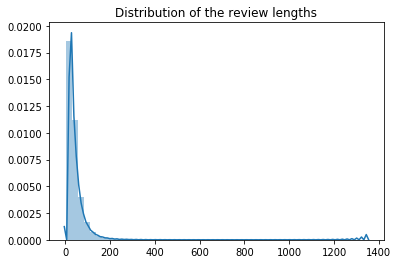

In [20]:
# plotting distributions of reviews lengths
ax = plt.axes()
sb.distplot(review_lengths)
ax.set_title("Distribution of the review lengths")
plt.plot()

from above plot it could be observed that most of the review length lies between 1 - 200 which means even if we try to try to 0 pad reviews to 300, 400, 500 we will not loose much information

In [21]:
# splitting reviews between train, test and Validation
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(sample['CleandText_NoStem_indexed'].values,sample['Score'],test_size = 0.3,random_state = 0,shuffle = False)

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(70000,)
(70000,)
(30000,)
(30000,)


In [23]:
X_train , X_val , y_train , y_val = train_test_split(X_train,y_train,test_size = 0.3,random_state = 0,shuffle = False)

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(49000,)
(49000,)
(30000,)
(30000,)
(21000,)
(21000,)


In [25]:
print(X_train[1])
print(type(X_train[1]))
print(len(X_train[1]))

[625, 1609, 1300, 0, 0, 74, 294, 1079, 1453, 552, 41, 58, 4711, 0, 36, 4460, 3288, 0, 3432, 0, 0, 698, 109, 1092, 612, 506, 3288, 872, 3424, 1971]
<class 'list'>
30


In [26]:
# Applying 0 padding to equalize all the reviews
# truncate and/or pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
X_val = sequence.pad_sequences(X_val, maxlen=max_review_length)
print(X_train.shape)
print(X_train[1])

(49000, 500)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [27]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(49000, 500)
(49000,)
(30000, 500)
(30000,)
(21000, 500)
(21000,)


In [ ]:
#### Function 

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plot_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

## **1 Layered LSTM using Keras (LSTM(100))**

In [29]:
# create the model
from keras.layers import Dropout
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_rank_word, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.5))

model.add(LSTM(100))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
history = model.fit(X_train, y_train, batch_size=256, epochs=10,verbose=1,validation_data=(X_val, y_val))

Train on 49000 samples, validate on 21000 samples
Epoch 1/10
49000/49000 [==============================] - 262s 5ms/step - loss: 0.2346 - acc: 0.9103 - val_loss: 0.2195 - val_acc: 0.9135
Epoch 2/10
49000/49000 [==============================] - 261s 5ms/step - loss: 0.1687 - acc: 0.9373 - val_loss: 0.2045 - val_acc: 0.9213
Epoch 3/10
49000/49000 [==============================] - 261s 5ms/step - loss: 0.1674 - acc: 0.9365 - val_loss: 0.2552 - val_acc: 0.8920
Epoch 4/10
49000/49000 [==============================] - 262s 5ms/step - loss: 0.2136 - acc: 0.9152 - val_loss: 0.2351 - val_acc: 0.9088
Epoch 5/10
49000/49000 [==============================] - 262s 5ms/step - loss: 0.1520 - acc: 0.9432 - val_loss: 0.2092 - val_acc: 0.9200
Epoch 6/10
49000/49000 [==============================] - 262s 5ms/step - loss: 0.1396 - acc: 0.9481 - val_loss: 0.2116 - val_acc: 0.9206
Epoch 7/10
49000/49000 [==============================] - 262s 5ms/step - loss: 0.1351 - acc: 0.9509 - val_loss: 0.2145 - 

In [32]:
# show the accuracy on the testing set
print("[INFO] evaluating...")
(loss, accuracy) = model.evaluate(X_test, y_test,batch_size=128, verbose=1,)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

[INFO] evaluating...
30000/30000 [==============================] - 85s 3ms/step
[INFO] accuracy: 91.60%


[INFO] accuracy: 91.91%


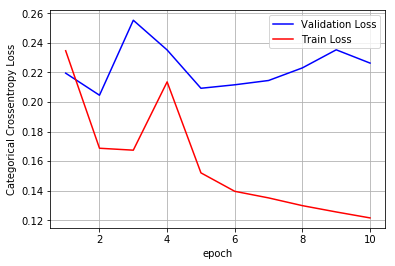

In [33]:
print("[INFO] accuracy: {:.2f}%".format(history.history['val_acc'][-1] * 100))
vy = history.history['val_loss']
ty = history.history['loss']

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,10+1))
plot_dynamic(x, vy, ty, ax)

- at epoch no. 4 Train_loss and Validation_loss have converged a lot but after that validation_loss is running at constant pace and train_loss is decreasing.

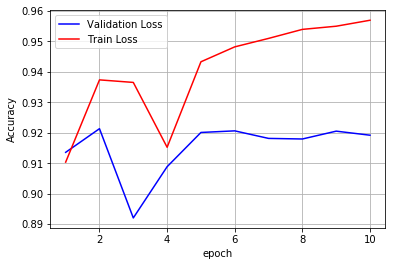

In [39]:

vy = history.history['val_acc']
ty = history.history['acc']

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Accuracy')

# list of epoch numbers
x = list(range(1,10+1))
plot_dynamic(x, vy, ty, ax)

- *Validation loss, train Loss have been wrongly written as single function was used it must be Validation Accuracy and Train Accuracy
- at epoch no. 4 we observe that the train and validation accuracy are best.

In [34]:
validation_loss = history.history['val_loss'][-1]
validation_acc = history.history['val_acc'][-1]
train_loss = history.history['loss'][-1]
train_acc = history.history['acc'][-1]
test_loss= loss
test_acc= accuracy

In [35]:
print(validation_loss,validation_acc,train_loss,train_acc,test_loss, test_acc)

0.2262719388433865 0.9191428571428572 0.1215683789715475 0.9568775510398709 0.2316194803317388 0.916


In [36]:
import pandas as pd
LSTM_summary = pd.DataFrame()
LSTM_summary['Model'] = ["LSTM(100)"]
LSTM_summary['train_accuracy'] = train_acc.round(4)
LSTM_summary['train_loss'] = train_loss.round(4)
LSTM_summary['validation_accuracy'] = validation_acc.round(4)
LSTM_summary['validation_loss'] = validation_loss.round(4)
LSTM_summary['test_accuracy'] = test_acc.round(4)
LSTM_summary['test_loss'] = test_loss.round(4)


In [37]:
LSTM_summary.to_csv('LSTM_summary.csv', index=False)

In [38]:
LSTM_summary

,Model,train_accuracy,train_loss,validation_accuracy,validation_loss,test_accuracy,test_loss
0,LSTM(100),0.9569,0.1216,0.9191,0.2263,0.916,0.2316


## **2 Layered LSTM using Keras (LSTM(100)-LSTM(50))**

In [29]:
# create the model
from keras.layers import Dropout
embedding_vecor_length = 32
model2 = Sequential()
model2.add(Embedding(top_rank_word, embedding_vecor_length, input_length=max_review_length))
model2.add(Dropout(0.5))

model2.add(LSTM(100, return_sequences=True))
model2.add(Dropout(0.5))

model2.add(LSTM(50))
model2.add(Dropout(0.5))

model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 100)          53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total para

In [30]:
history = model2.fit(X_train, y_train, batch_size=256, epochs=10,verbose=1,validation_data=(X_val, y_val))

Train on 49000 samples, validate on 21000 samples
Epoch 1/10
49000/49000 [==============================] - 527s 11ms/step - loss: 0.3068 - acc: 0.8976 - val_loss: 0.2118 - val_acc: 0.9172
Epoch 2/10
49000/49000 [==============================] - 526s 11ms/step - loss: 0.1843 - acc: 0.9312 - val_loss: 0.2427 - val_acc: 0.9153
Epoch 3/10
49000/49000 [==============================] - 527s 11ms/step - loss: 0.1610 - acc: 0.9405 - val_loss: 0.2049 - val_acc: 0.9210
Epoch 4/10
49000/49000 [==============================] - 529s 11ms/step - loss: 0.1491 - acc: 0.9458 - val_loss: 0.2080 - val_acc: 0.9203
Epoch 5/10
49000/49000 [==============================] - 528s 11ms/step - loss: 0.1408 - acc: 0.9491 - val_loss: 0.2124 - val_acc: 0.9209
Epoch 6/10
49000/49000 [==============================] - 527s 11ms/step - loss: 0.1338 - acc: 0.9516 - val_loss: 0.2199 - val_acc: 0.9217
Epoch 7/10
49000/49000 [==============================] - 527s 11ms/step - loss: 0.1283 - acc: 0.9548 - val_loss: 0.

In [31]:
# show the accuracy on the testing set
print("[INFO] evaluating...")
(loss, accuracy) = model2.evaluate(X_test, y_test,batch_size=256, verbose=1,)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

[INFO] evaluating...
30000/30000 [==============================] - 86s 3ms/step
[INFO] accuracy: 91.43%


[INFO] accuracy: 91.57%


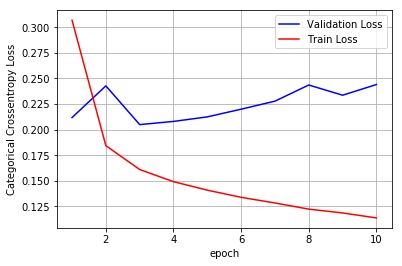

In [32]:
print("[INFO] accuracy: {:.2f}%".format(history.history['val_acc'][-1] * 100))
vy = history.history['val_loss']
ty = history.history['loss']

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,10+1))
plot_dynamic(x, vy, ty, ax)

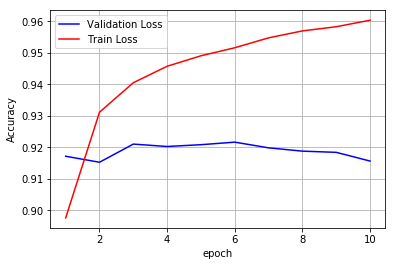

In [33]:

vy = history.history['val_acc']
ty = history.history['acc']

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Accuracy')

# list of epoch numbers
x = list(range(1,10+1))
plot_dynamic(x, vy, ty, ax)

- Very clearly we can observe that after 1 epoch a train and test loss, accuracy are constantly diverging i.e. they are trying to overfit.

In [34]:
validation_loss = history.history['val_loss'][-1]
validation_acc = history.history['val_acc'][-1]
train_loss = history.history['loss'][-1]
train_acc = history.history['acc'][-1]
test_loss= loss
test_acc= accuracy

In [35]:
print(validation_loss,validation_acc,train_loss,train_acc,test_loss, test_acc)

0.24397905156442098 0.9156666666666666 0.11372921771176007 0.9603673469485069 0.24930914423465728 0.9142999999682109


In [36]:
list = ["LSTM(100)-LSTM(50)",train_acc.round(4),train_loss.round(4),validation_acc.round(4),validation_loss.round(4),test_acc.round(4),test_loss.round(4)]


In [37]:
LSTM_summ = pd.read_csv("./LSTM_summary.csv", engine = "python")
LSTM_summ

,Model,train_accuracy,train_loss,validation_accuracy,validation_loss,test_accuracy,test_loss
0,LSTM(100),0.9569,0.1216,0.9191,0.2263,0.916,0.2316


In [38]:
LSTM_summ = LSTM_summ.append(pd.Series(list, index=['Model','train_accuracy','train_loss','validation_accuracy','validation_loss','test_accuracy','test_loss']), ignore_index=True)

In [39]:
LSTM_summ

,Model,train_accuracy,train_loss,validation_accuracy,validation_loss,test_accuracy,test_loss
0,LSTM(100),0.9569,0.1216,0.9191,0.2263,0.9160,0.2316
1,LSTM(100)-LSTM(50),0.9604,0.1137,0.9157,0.2440,0.9143,0.2493


In [40]:
LSTM_summ.to_csv('LSTM_summary.csv', index=False)

# **LSTM using Tensorflow**

In [108]:
import tensorflow as tf
from collections import Counter

In [109]:
# Loading already cleaned datafile
final = pd.read_csv("./final.csv", engine = "python")
print(final.shape)

(364171, 14)


In [110]:
###Sorting as we want according to time 
final.sort_values('Time',inplace=True)

In [111]:
filtered_df = final[final['CleanedText_NoStem'].notnull()]
filtered_df.shape

(364168, 14)

In [112]:
    i=0
    all_words=[] # store words from +ve reviews here
    for sent in tqdm(filtered_df['CleanedText_NoStem'].astype(str).values):
        for w in sent.split():
            w=(w.lower())
            all_words.append(w)


100%|██████████| 364168/364168 [00:05<00:00, 61139.93it/s]


In [113]:
freq_dist=nltk.FreqDist(all_words)
print("frequenies of Words : ",freq_dist.most_common(20))

frequenies of Words :  [('not', 198672), ('like', 152093), ('good', 121423), ('great', 106024), ('one', 104198), ('taste', 102063), ('product', 95543), ('coffee', 85790), ('flavor', 85291), ('tea', 83561), ('love', 79221), ('would', 72981), ('get', 66662), ('really', 61746), ('food', 61246), ('dont', 57474), ('use', 56738), ('much', 56452), ('also', 53050), ('time', 51719)]


In [114]:
vocabulary = dict(freq_dist)

In [115]:
def top_words(top,vocab):
    #https://docs.python.org/3/library/operator.html
    import operator
    sorted_vocab = sorted(vocab.items(), key=operator.itemgetter(1),reverse = True)
    sorted_vocab=sorted_vocab[1:top+1] # eliminated not by starting from index 1 
    
    ranking = dict()
    rank = 1
    for i in range(len(sorted_vocab)):
        k = sorted_vocab[i][0]
        ranking[k] = rank
        rank+=1
    return ranking

In [116]:
top_rank_word = 5000
ranking = top_words(top_rank_word, vocabulary)


In [117]:
X = []    
for sent in tqdm(filtered_df['CleanedText_NoStem'].astype(str).values):
    row =[]
    for w in sent.split():
        if w in ranking:
            row.append(ranking[w]) 
        else:
            row.append(0)    
            
    X.append(row)
    
filtered_df['CleandText_NoStem_indexed'] = X

filtered_df['Score'] = filtered_df['Score'].map(lambda x : 1 if x == 'positive' else 0)
filtered_df.head(5)

100%|██████████| 364168/364168 [00:10<00:00, 34137.77it/s]
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText_NoStem,CleanedText,CleanedText_NoStem_utf,CleanedText_utf,CleandText_NoStem_indexed
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08 00:00:00,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...,witti littl book make son laugh loud recit car...,b'witty little book makes son laugh loud recit...,b'witti littl book make son laugh loud recit c...,"[0, 20, 1414, 77, 396, 4915, 4419, 0, 1267, 32..."
30,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25 00:00:00,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...,rememb see show air televis year ago child sis...,b'remember seeing show aired television years ...,b'rememb see show air televis year ago child s...,"[625, 1609, 1300, 0, 0, 74, 294, 1079, 1453, 5..."
424,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,1999-12-02 00:00:00,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything exce...,beetlejuic well written movi everyth excel act...,b'beetlejuice well written movie everything ex...,b'beetlejuic well written movi everyth excel a...,"[0, 30, 2338, 1534, 330, 160, 0, 455, 1219, 14..."
330,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,1999-12-06 00:00:00,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...,twist rumplestiskin captur film star michael k...,b'twist rumplestiskin captured film starring m...,b'twist rumplestiskin captur film star michael...,"[2594, 0, 0, 3425, 0, 0, 0, 0, 0, 992, 4198, 0..."
423,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,2000-01-03 00:00:00,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent funny movie keaton hilar...,beetlejuic excel funni movi keaton hilari wack...,b'beetlejuice excellent funny movie keaton hil...,b'beetlejuic excel funni movi keaton hilari wa...,"[0, 160, 1631, 1534, 0, 0, 0, 0, 3, 455, 1219,..."


In [118]:
#Taking latest Data
n_samples = 100000
sample = filtered_df.head(n_samples)

In [119]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(sample['CleandText_NoStem_indexed'].values,sample['Score'],test_size = 0.3,random_state = 0,shuffle = False)

In [120]:
X_train , X_val , y_train , y_val = train_test_split(X_train,y_train,test_size = 0.3,random_state = 0,shuffle = False)

In [121]:
print(X_train[1])
print(type(X_train[1]))
print(len(X_train[1]))

[625, 1609, 1300, 0, 0, 74, 294, 1079, 1453, 552, 41, 58, 4711, 0, 36, 4460, 3288, 0, 3432, 0, 0, 698, 109, 1092, 612, 506, 3288, 872, 3424, 1971]
<class 'list'>
30


In [122]:

# truncate and/or pad input sequences
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
X_val = sequence.pad_sequences(X_val, maxlen=max_review_length)
print(X_train.shape)
print(X_train[1])

(49000, 500)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

In [123]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(49000, 500)
(49000,)
(30000, 500)
(30000,)
(21000, 500)
(21000,)


In [ ]:
#reference : https://www.oreilly.com/ideas/introduction-to-lstms-with-tensorflow

In [65]:
def model_inputs():
    """ Create the model inputs """
    inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs')
    labels_ = tf.placeholder(tf.int32, [None, None], name='labels')
    keep_prob_ = tf.placeholder(tf.float32, name='keep_prob')
    
    return inputs_, labels_, keep_prob_

In [51]:
def build_embedding_layer(inputs_, vocab_size, embed_size):
    """ Create the embedding layer """
    embedding = tf.Variable(tf.random_uniform((vocab_size, embed_size), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs_)
    print(" embeddings shape ",embed.shape)
    
    return embed

In [52]:
def build_lstm_layers(lstm_sizes, embed, keep_prob_, batch_size):
    """ Create the LSTM layers """
    lstms = [tf.contrib.rnn.BasicLSTMCell(size) for size in lstm_sizes]
    # Add dropout to the cell
    drops = [tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_) for lstm in lstms]
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell(drops)
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    lstm_outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)
    print("Shape of LSTM layers \n", final_state)
    
    return initial_state, lstm_outputs, cell, final_state

In [24]:
def build_cost_fn_and_opt(lstm_outputs, labels_, learning_rate):
    """ Create the Loss function and Optimizer """
    predictions = tf.contrib.layers.fully_connected(lstm_outputs[:, -1], 1, activation_fn=tf.sigmoid)
    loss = tf.losses.mean_squared_error(labels_, predictions)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    print("Shape of fully connected layer ", predictions.shape)
    
    return predictions, loss, optimizer

In [55]:
def build_accuracy(predictions, labels_):
    """ Create accuracy """
    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    return accuracy

In [26]:
def build_accuracy(predictions, labels_):
    """ Create accuracy """
    #Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image. and both will be a column vector.
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(labels_, 1))

    #calculate accuracy across all the given images and average them out. 
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return accuracy

In [27]:
def get_batches(x, y, batch_size=100):
    """
    Batch Generator for Training
    :param x: Input array of x data
    :param y: Input array of y data
    :param batch_size: Input int, size of batch
    :return: generator that returns a tuple of our x batch and y batch
    """
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [95]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
def plt_dynamic(x, y, y_1, ax, colors=['b']):
    ax.plot(x, y, 'b', label="Train Loss")
    ax.plot(x, y_1, 'r', label="Test Loss")
    if len(x)==1:
        plt.legend()
    fig.canvas.draw()

## **1 layered LSTM using Tensorflow(LSTM(100))**

In [124]:

# Define Inputs and Hyperparameters
lstm_sizes = [100]
vocab_size = top_rank_word 
embed_size = 32
epochs = 10
batch_size = 256
learning_rate = 0.001
keep_prob = 0.5
dropout=0.5

In [125]:
def build_and_train_network(lstm_sizes, vocab_size, embed_size, epochs, batch_size,
                            learning_rate, keep_prob, X_train, X_val, y_train, y_val):
    
    inputs_, labels_, keep_prob_ = model_inputs()
    embed = build_embedding_layer(inputs_, vocab_size, embed_size)
    initial_state, lstm_outputs, lstm_cell, final_state = build_lstm_layers(lstm_sizes, embed, keep_prob_, batch_size)
    predictions, loss, optimizer = build_cost_fn_and_opt(lstm_outputs, labels_, learning_rate)
    accuracy = build_accuracy(predictions, labels_)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        n_batches = len(X_train)//batch_size
        xs =[]
        train_acc = []
        train_loss = []
        validation_acc = []
        validation_loss =[]
        for e in range(epochs):
            state = sess.run(initial_state)
            

            for ii, (x, y) in enumerate(get_batches(X_train, y_train, batch_size), 1):
                feed = {inputs_: x, labels_: y[:, None], keep_prob_: 0.5, initial_state: state}
                loss_, state, _,  batch_acc = sess.run([loss, final_state, optimizer, accuracy], feed_dict=feed)
            
            train_acc.append(batch_acc)
            train_loss.append(loss_)
                
            val_state = sess.run(lstm_cell.zero_state(batch_size, tf.float32))
            for xx, yy in get_batches(X_val, y_val, batch_size):
                feed = {inputs_: xx,labels_: yy[:, None],keep_prob_: 1, initial_state: val_state}
                val_loss, val_batch_acc, val_state = sess.run([loss, accuracy, final_state], feed_dict=feed)
            validation_acc.append(val_batch_acc)
            validation_loss.append(val_loss)
            xs.append(e)
                
                    
            print("Epoch: {}/{}...".format(e+1, epochs),
                          "Batch: {}/{}...".format(ii, n_batches),
                          "Train Loss: {:.3f}...".format(loss_),
                          "Train Accruacy: {:.3f}...".format((batch_acc)),
                          "Val Loss: {:.3f}...".format((val_loss)),
                          "Val Accuracy: {:.3f}".format((val_batch_acc)))
    
        saver.save(sess, "checkpoints/sentiment.ckpt")
        return train_acc, train_loss, validation_acc, validation_loss,xs

In [126]:
%%time
with tf.Graph().as_default():
    train_acc,train_loss,val_acc,val_loss,xs =  build_and_train_network(lstm_sizes, vocab_size, embed_size, epochs, batch_size,
                                                                   learning_rate, dropout, X_train, X_val, y_train, y_val)

 embeddings shape  (?, ?, 32)
Shape of LSTM layers 
 (LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(256, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(256, 100) dtype=float32>),)
Shape of fully connected layer  (256, 1)
Epoch: 1/10... Batch: 191/191... Train Loss: 0.117... Train Accruacy: 0.863... Val Loss: 0.095... Val Accuracy: 0.883
Epoch: 2/10... Batch: 191/191... Train Loss: 0.092... Train Accruacy: 0.871... Val Loss: 0.072... Val Accuracy: 0.902
Epoch: 3/10... Batch: 191/191... Train Loss: 0.078... Train Accruacy: 0.887... Val Loss: 0.064... Val Accuracy: 0.922
Epoch: 4/10... Batch: 191/191... Train Loss: 0.066... Train Accruacy: 0.906... Val Loss: 0.065... Val Accuracy: 0.910
Epoch: 5/10... Batch: 191/191... Train Loss: 0.061... Train Accruacy: 0.918... Val Loss: 0.062... Val Accuracy: 0.914
Epoch: 6/10... Batch: 191/191... Train Loss: 0.052... Train Accruacy: 0.930... Val Loss: 0.065... Val Accuracy: 0.914
Epoch: 7/10... Batch: 191/191... Train Loss: 0

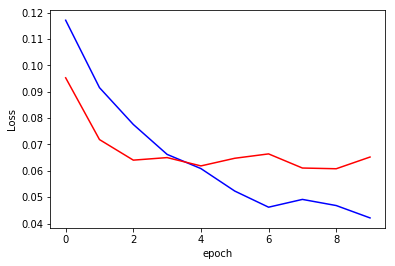

In [127]:
xs = range(10)
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Loss')
plt_dynamic(xs, train_loss, val_loss, ax)   

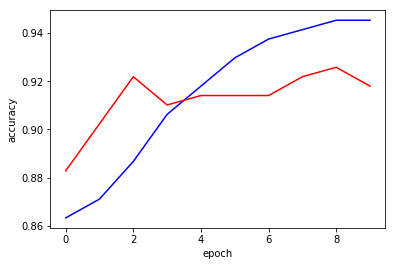

In [128]:

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('accuracy')
plt_dynamic(xs, train_acc, val_acc, ax)   

- similar to 1 Layered LSTM model using keras here also we are getting best loss and accuracy values at epoch no. 4

In [129]:
def test_network(model_dir, batch_size, test_x, test_y):
    
    inputs_, labels_, keep_prob_ = model_inputs()
    embed = build_embedding_layer(inputs_, vocab_size, embed_size)
    initial_state, lstm_outputs, lstm_cell, final_state = build_lstm_layers(lstm_sizes, embed, keep_prob_, batch_size)
    predictions, loss, optimizer = build_cost_fn_and_opt(lstm_outputs, labels_, learning_rate)
    accuracy = build_accuracy(predictions, labels_)
    
    saver = tf.train.Saver()
    
    test_acc = []
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        test_state = sess.run(lstm_cell.zero_state(batch_size, tf.float32))
        for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
            feed = {inputs_: x, labels_: y[:, None], keep_prob_: 1, initial_state: test_state}
            batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
            test_acc.append(batch_acc)
        avg_test_acc=np.mean(test_acc)
        print("Test Accuracy: {:.3f}".format(np.mean(avg_test_acc)))
        return avg_test_acc

In [130]:
with tf.Graph().as_default():
    test_acc=test_network('checkpoints', batch_size, X_test, y_test)

 embeddings shape  (?, ?, 32)
Shape of LSTM layers 
 (LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(256, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(256, 100) dtype=float32>),)
Shape of fully connected layer  (256, 1)
INFO:tensorflow:Restoring parameters from checkpoints/sentiment.ckpt
Test Accuracy: 0.913


In [131]:
import pandas as pd
tf_LSTM_summ = pd.read_csv("./tf_LSTM_summary.csv", engine = "python")

In [132]:
tf_LSTM_summ

,Model,train avg cost,Val_avg_cost,train_accuracy,Val_accuracy,test_accuracy
0,2 layer LSTM model,0.034784,0.0607,0.9648,0.918,0.916


In [134]:
list = ["1(100) Layered LSTM",train_loss[-1],val_loss[-1].round(4),train_acc[-1].round(4),val_acc[-1].round(4), test_acc.round(4)]


In [138]:
tf_LSTM_summ = tf_LSTM_summ.append(pd.Series(list, index=['Model','train avg cost','Val_avg_cost', 'train_accuracy', 'Val_accuracy', 'test_accuracy']), ignore_index=True)



In [139]:
tf_LSTM_summ.to_csv('tf_LSTM_summary.csv', index=False)

In [140]:
tf_LSTM_summ

,Model,train avg cost,Val_avg_cost,train_accuracy,Val_accuracy,test_accuracy
0,2 layer LSTM model,0.034784,0.0607,0.9648,0.918,0.9160
1,1(100) Layered LSTM,0.042119,0.0652,0.9453,0.918,0.9129


## **2 Layer LSTM using tensorflow(LSTM(100)-LSTM(50))**

In [88]:

# Define Inputs and Hyperparameters
lstm_sizes = [100, 50]
vocab_size = top_rank_word 
embed_size = 32
epochs = 10
batch_size = 256
learning_rate = 0.001
keep_prob = 0.5
dropout=0.5

In [89]:
def build_and_train_network(lstm_sizes, vocab_size, embed_size, epochs, batch_size,
                            learning_rate, keep_prob, X_train, X_val, y_train, y_val):
    
    inputs_, labels_, keep_prob_ = model_inputs()
    embed = build_embedding_layer(inputs_, vocab_size, embed_size)
    initial_state, lstm_outputs, lstm_cell, final_state = build_lstm_layers(lstm_sizes, embed, keep_prob_, batch_size)
    predictions, loss, optimizer = build_cost_fn_and_opt(lstm_outputs, labels_, learning_rate)
    accuracy = build_accuracy(predictions, labels_)
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        
        sess.run(tf.global_variables_initializer())
        n_batches = len(X_train)//batch_size
        xs =[]
        train_acc = []
        train_loss = []
        validation_acc = []
        validation_loss =[]
        for e in range(epochs):
            state = sess.run(initial_state)
            

            for ii, (x, y) in enumerate(get_batches(X_train, y_train, batch_size), 1):
                feed = {inputs_: x, labels_: y[:, None], keep_prob_: 0.5, initial_state: state}
                loss_, state, _,  batch_acc = sess.run([loss, final_state, optimizer, accuracy], feed_dict=feed)
            
            train_acc.append(batch_acc)
            train_loss.append(loss_)
                
            val_state = sess.run(lstm_cell.zero_state(batch_size, tf.float32))
            for xx, yy in get_batches(X_val, y_val, batch_size):
                feed = {inputs_: xx,labels_: yy[:, None],keep_prob_: 1, initial_state: val_state}
                val_loss, val_batch_acc, val_state = sess.run([loss, accuracy, final_state], feed_dict=feed)
            validation_acc.append(val_batch_acc)
            validation_loss.append(val_loss)
            xs.append(e)
                
                    
            print("Epoch: {}/{}...".format(e+1, epochs),
                          "Batch: {}/{}...".format(ii, n_batches),
                          "Train Loss: {:.3f}...".format(loss_),
                          "Train Accruacy: {:.3f}...".format((batch_acc)),
                          "Val Loss: {:.3f}...".format((val_loss)),
                          "Val Accuracy: {:.3f}".format((val_batch_acc)))
    
        saver.save(sess, "checkpoints/sentiment.ckpt")
        return train_acc, train_loss, validation_acc, validation_loss,xs

In [90]:
%%time
with tf.Graph().as_default():
    train_acc,train_loss,val_acc,val_loss,xs =  build_and_train_network(lstm_sizes, vocab_size, embed_size, epochs, batch_size,
                                                                   learning_rate, dropout, X_train, X_val, y_train, y_val)

 embeddings shape  (?, ?, 32)
Shape of LSTM layers 
 (LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(256, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(256, 100) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_5:0' shape=(256, 50) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_6:0' shape=(256, 50) dtype=float32>))
Shape of fully connected layer  (256, 1)
Epoch: 1/10... Batch: 191/191... Train Loss: 0.119... Train Accruacy: 0.863... Val Loss: 0.104... Val Accuracy: 0.883
Epoch: 2/10... Batch: 191/191... Train Loss: 0.102... Train Accruacy: 0.879... Val Loss: 0.077... Val Accuracy: 0.902
Epoch: 3/10... Batch: 191/191... Train Loss: 0.083... Train Accruacy: 0.906... Val Loss: 0.052... Val Accuracy: 0.938
Epoch: 4/10... Batch: 191/191... Train Loss: 0.067... Train Accruacy: 0.910... Val Loss: 0.054... Val Accuracy: 0.922
Epoch: 5/10... Batch: 191/191... Train Loss: 0.056... Train Accruacy: 0.930... Val Loss: 0.056... Val Accuracy: 0.926
Epoch: 6/10... Ba

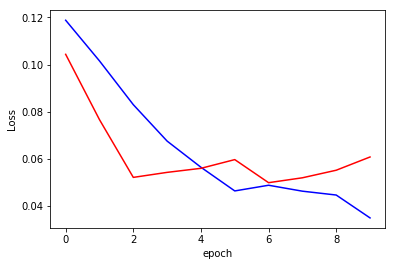

In [98]:
xs = range(10)
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Loss')
plt_dynamic(xs, train_loss, val_loss, ax)   

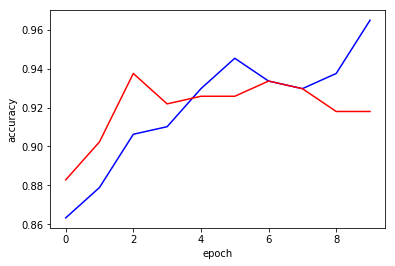

In [99]:

fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('accuracy')
plt_dynamic(xs, train_acc, val_acc, ax)   

In [100]:
def test_network(model_dir, batch_size, test_x, test_y):
    
    inputs_, labels_, keep_prob_ = model_inputs()
    embed = build_embedding_layer(inputs_, vocab_size, embed_size)
    initial_state, lstm_outputs, lstm_cell, final_state = build_lstm_layers(lstm_sizes, embed, keep_prob_, batch_size)
    predictions, loss, optimizer = build_cost_fn_and_opt(lstm_outputs, labels_, learning_rate)
    accuracy = build_accuracy(predictions, labels_)
    
    saver = tf.train.Saver()
    
    test_acc = []
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        test_state = sess.run(lstm_cell.zero_state(batch_size, tf.float32))
        for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
            feed = {inputs_: x, labels_: y[:, None], keep_prob_: 1, initial_state: test_state}
            batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
            test_acc.append(batch_acc)
        avg_test_acc=np.mean(test_acc)
        print("Test Accuracy: {:.3f}".format(np.mean(avg_test_acc)))
        return avg_test_acc

In [101]:
with tf.Graph().as_default():
    test_acc=test_network('checkpoints', batch_size, X_test, y_test)

 embeddings shape  (?, ?, 32)
Shape of LSTM layers 
 (LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(256, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(256, 100) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_5:0' shape=(256, 50) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_6:0' shape=(256, 50) dtype=float32>))
Shape of fully connected layer  (256, 1)
INFO:tensorflow:Restoring parameters from checkpoints/sentiment.ckpt
Test Accuracy: 0.916


In [102]:
import pandas as pd

In [103]:

tf_LSTM_summary = pd.DataFrame()
tf_LSTM_summary['Model'] = ["2 layer LSTM model"]
tf_LSTM_summary['train avg cost'] = train_loss[-1]
tf_LSTM_summary['Val_avg_cost'] = val_loss[-1].round(4)
tf_LSTM_summary['train_accuracy'] = train_acc[-1].round(4)
tf_LSTM_summary['Val_accuracy'] = val_acc[-1].round(4)
tf_LSTM_summary['test_accuracy'] = test_acc.round(4)

In [104]:
tf_LSTM_summary.to_csv('tf_LSTM_summary.csv', index=False)

In [105]:
tf_LSTM_summ = pd.read_csv("./tf_LSTM_summary.csv", engine = "python")
tf_LSTM_summ

,Model,train avg cost,Val_avg_cost,train_accuracy,Val_accuracy,test_accuracy
0,2 layer LSTM model,0.034784,0.0607,0.9648,0.918,0.916


In [41]:
print("LSTM summary table using tensorflow")
tf_LSTM_summ = pd.read_csv("./tf_LSTM_summary.csv", engine = "python")
tf_LSTM_summ

LSTM summary table using tensorflow


,Model,train avg cost,Val_avg_cost,train_accuracy,Val_accuracy,test_accuracy
0,2 layer LSTM model,0.034784,0.0607,0.9648,0.918,0.9160
1,1(100) Layered LSTM,0.042119,0.0652,0.9453,0.918,0.9129


In [42]:
print("LSTM summary table using Keras")
LSTM_summ = pd.read_csv("./LSTM_summary.csv", engine = "python")
LSTM_summ

LSTM summary table using Keras


,Model,train_accuracy,train_loss,validation_accuracy,validation_loss,test_accuracy,test_loss
0,LSTM(100),0.9569,0.1216,0.9191,0.2263,0.9160,0.2316
1,LSTM(100)-LSTM(50),0.9604,0.1137,0.9157,0.2440,0.9143,0.2493


**Summarizing**
    - we can very well observe that 1-layered or 2-layered model either with Keras or Tensorflow have showed almost similar performance as if we check test accuracy of 1-layered model it is appx 91% and for 2 layered model it is also 91% for both tensorflow and keras, same similarities can be observed for train and validation accuracies.
    - Training LSTMs with very large data corpus is a slow process and it may easily overfit.
    - In summary, LSTM networks are an extension of RNNs that are designed to handle the problem of learning long-term dependencies. LSTMs have broad-reaching applications when dealing with sequential data and are often used for NLP tasks. 
    